# TP2 : Expectation-Maximisation algorithm – Importance sampling

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import logsumexp
from scipy.stats import multivariate_normal 

## Exercise 1: Discrete distributions

In [220]:
def discrete_distribution(x, p, size=1) : 
    n = len(p)
    c = np.array([np.sum(p[:i]) for i in range(1, n)]+ [1])
    U = np.random.uniform(0, 1, size)
    b = np.zeros((n, size))
    b[0] = (U<=c[0])
    for i in range(1, n) :
        b[i] = (c[i-1]<=U)*(U<c[i])
    X = np.einsum("i, ik->k", x, b)
    return X

In [283]:
k=5
x = np.arange(k) #np.array([1, 2, 3, 4, 5, 6])
p = np.random.normal(size=k)
p = np.exp(p - logsumexp(p))
print(p, np.sum(p))

[0.05722286 0.06569823 0.34459627 0.30777931 0.22470333] 1.0


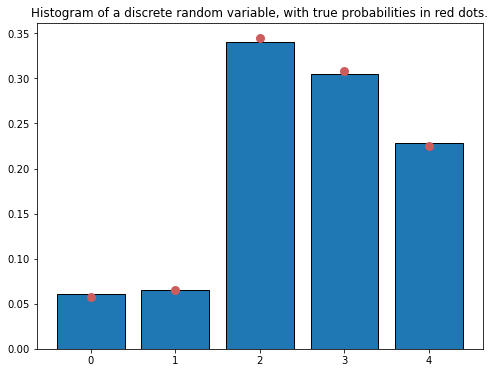

In [284]:
X = discrete_distribution(x, p, 20_000)
fig = plt.figure(figsize=(8, 6))
plt.hist(X, bins=range(np.min(x), np.max(x) + 2), align='left', rwidth=0.8, edgecolor="k", density="True")
plt.scatter(x, p, marker='o', color="indianred", lw=3)
plt.title("Histogram of a discrete random variable, with true probabilities in red dots.")
plt.show()

## Exercise 2: Gaussian mixture model and the EM algorithm

### Point technique : Log-Sum-Exp Trick

À l'étape (E), on calcule : 

$$ \tau_{i, j} \propto \frac{\alpha_j}{\sqrt{2\pi|\Sigma_j|}^d}\exp\left(-\frac{(x_i-\mu_j)^T \Sigma_j^{-1} (x_i-\mu_j)}{2} \right) $$

L'argument dans l'exponentielle est potentiellement très faible ce qui peut donner un terme nul et entrainer des divisions par zéro indésirables.

In [349]:
def draw_ellipse(sigma, mu, scale=6) :
    '''draw an ellipse of center mu and psd matrix sigma'''
    U, d, V = np.linalg.svd(sigma)
    t = np.linspace(0, 2*np.pi, 200)
    y1 = np.cos(t)*np.sqrt(scale*d[0])
    y2 = np.sin(t)*np.sqrt(scale*d[1])
    x1 = mu[0] + U[0,0]*y1 + U[0,1]*y2
    x2 = mu[1] + U[1,0]*y1 + U[1,1]*y2
    plt.plot(x1, x2, color="k")

In [373]:
d = 2
p = 5
n = 5000

In [386]:
mu = np.random.uniform(-15, 15, size=(p, d))
sigma = np.random.normal(size=(p, d, d))
for j in range(p):
    sigma[j] = np.dot(sigma[j], sigma[j].T)

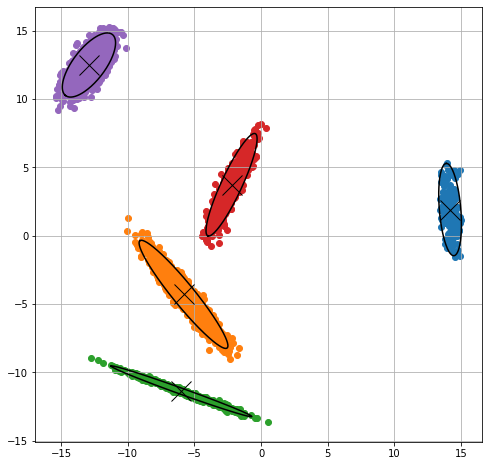

In [387]:
X=np.zeros((n,d))
fig = plt.figure(figsize=(8, 8))
k=0
alpha = np.random.normal(size=p)
alpha = np.exp(alpha - logsumexp(alpha))

n_samples = np.zeros(p).astype(int)
Z = discrete_distribution(list(range(p)), alpha, n)
for j in range(p) :
    n_samples[j] = np.sum(Z==j)

for j in range(p) :
    x = np.random.multivariate_normal(mu[j], sigma[j], n_samples[j])
    X[k:k+n_samples[j],:] = x
    plt.scatter(x[:,0], x[:,1], alpha=1)
    draw_ellipse(sigma[j], mu[j])
    plt.plot(mu[j, 0], mu[j, 1], marker="x", markersize=20, color="k")
    k+=n_samples[j]
plt.grid()
plt.show()

In [392]:
def EM(x, p=4, N_ITER=100) :
    n = len(x)
    d = len(x[0])
    cst = -d/2*np.log(2*np.pi)
    ## parameters initialization
    alpha = np.ones(p)/p
    k = np.random.choice(range(n), size=p)
    mu = np.zeros((p,d))
    mu = x[k]
    sigma2 = np.mean((x - np.mean(x, axis=0))**2)
    sigma = np.random.normal(size=(p, d, d))
    for j in range(p):
        sigma[j] = sigma2*np.eye(d)/p #10*np.dot(sigma[j], sigma[j].T)
    
    tau = np.ones((p, n))/p
    log_pdfs = np.ones((p, n))
    
    for _ in range(N_ITER) :
        ## Expectation Step
        for j in range(p) :
            _, slogdet = np.linalg.slogdet(sigma[j])
            invers_sigma = np.linalg.inv(sigma[j])
            log_pdfs[j] = cst - slogdet/2 - np.einsum("ik, il, kl -> i", x-mu[j], x-mu[j], invers_sigma)/2
        
        log_alpha = np.log(alpha)
        log_weighted_pdfs = (log_pdfs.T + log_alpha).T
        tau = np.exp(log_weighted_pdfs - logsumexp(log_weighted_pdfs, axis=0))
        ## Maximization Step

        for j in range(p) :
            Nj = np.sum(tau[j,:])
            mu[j] = np.einsum("i, ik -> k", tau[j,:], x) / Nj
            sigma[j] = np.einsum("k, ki, kj -> ij", tau[j,:], x-mu[j], x-mu[j]) / Nj
            alpha[j] = Nj / n 
    
    return mu, sigma, alpha

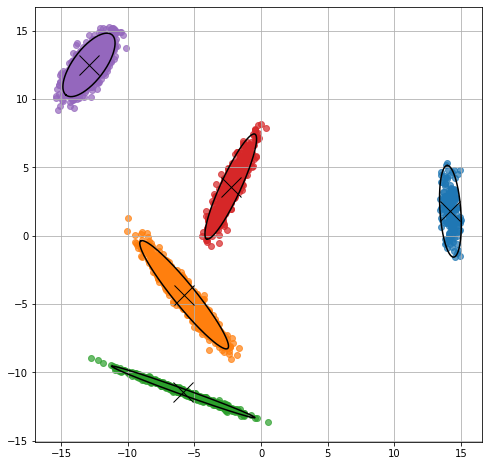

In [397]:
mu1, sigma1, alphas = EM(X, p=5, N_ITER=60)
fig = plt.figure(figsize=(8, 8))
k=0
for j in range(p) :
    x = X[k:k+n_samples[j],:]
    plt.scatter(x[:,0], x[:,1], alpha=0.7)
    draw_ellipse(sigma1[j], mu1[j])
    plt.plot(mu1[j, 0], mu1[j, 1], marker="x", markersize=20, color="k")
    k+=n_samples[j]
plt.grid()
plt.show()

Les paramètres estimés par l'algorithme EM varient d'une execution à l'autre. L'algorithme peut se rapprocher de très près des vrais paramètres. 

### Application au jeu de données "Crude Birth/Death Rate"

In [329]:
table = pd.read_csv("WPP2019_Period_Indicators_Medium.csv", sep=",", low_memory=False)
table = table[["CBR", "CDR"]].dropna()
table = table.values

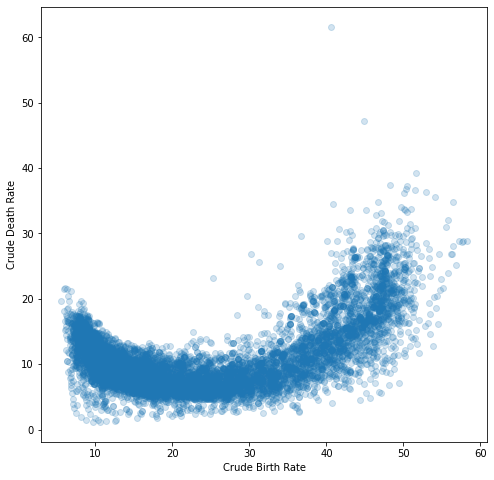

In [366]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(table[:,0], table[:,1], alpha=0.2)
plt.xlabel("Crude Birth Rate")
plt.ylabel("Crude Death Rate")
plt.show()

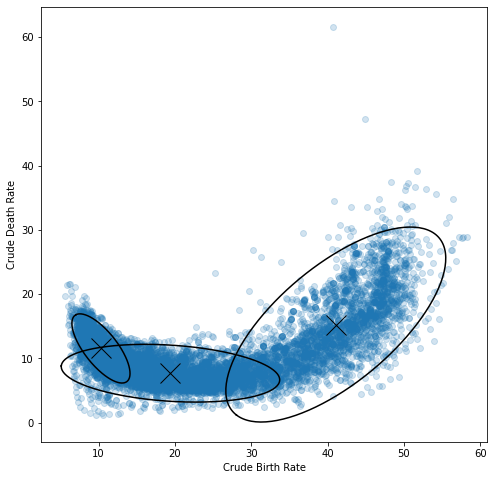

In [367]:
mu, sigma, alphas = EM(table, p=3, N_ITER=60)
fig = plt.figure(figsize=(8, 8))
for j in range(3) :
    draw_ellipse(sigma[j], mu[j])
    plt.plot(mu[j, 0], mu[j, 1], marker="x", markersize=20, color="k")

plt.scatter(table[:,0], table[:,1], alpha=0.2)
plt.xlabel("Crude Birth Rate")
plt.ylabel("Crude Death Rate")
plt.show()

Les taux de natalités et de mortalités dépendent d'un pays et d'une période temporelle. On peut distinguer un groupe "faible mortalité, faible natalité" à gauche, un autre "forte mortalité, forte natalité" et un troisième "faible mortalité, natalité moyenne". L'algorithme EM permet donc de classifier les données de manière interprétable.

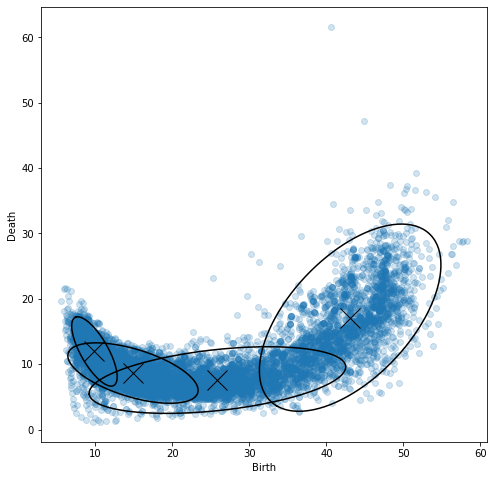

In [372]:
p = 4
mu, sigma, alphas = EM(table, p, N_ITER=60)
fig = plt.figure(figsize=(8, 8))
for j in range(p) :
    draw_ellipse(sigma[j], mu[j])
    plt.plot(mu[j, 0], mu[j, 1], marker="x", markersize=20, color="k")

plt.scatter(table[:,0], table[:,1], alpha=0.2)
plt.xlabel("Birth")
plt.ylabel("Death")
plt.show()

### Sélection de modèle - Bayesian Information Criterion

Comptons le nombre de paramètres et degrés de libertés d'un modèle de mélange gaussien avec $p$ composantes : 
- $\alpha_j : p$ paramètres avec la contrainte $\displaystyle\sum_{j=1}^p{\alpha_j} = 1$ d'où  l'on tire $p-1$ degrés de libertés.
- $\mu_j : p\times d$ paramètres indépendants d'où $p\times d$ degrés de libertés.
- $\Sigma_j : \displaystyle p\times d^2 $ paramètres avec la contrainte $\Sigma^T = \Sigma$ d'où $ p\times \frac{d(d+1)}{2}$ degrés de libertés.

Le nombre total de degrés de libertés est donc $p\times(d+1)\times(d + 2)/2 - 1$

In [333]:
def BIC(x, mu, sigma, alpha, p) :
    n = len(x)
    d = len(x[0])
    cst = -d*np.log(2*np.pi)/2
    BIC = 0
    log_pdfs = np.ones((p, n))
    
    for j in range(p) :
        _, slogdet = np.linalg.slogdet(sigma[j])
        invers_sigma = np.linalg.inv(sigma[j])
        log_pdfs[j] = cst - slogdet/2 - np.einsum("ik, il, kl -> i", x-mu[j], x-mu[j], invers_sigma)/2

    log_alpha = np.log(alpha)
    log_weighted_pdfs = (log_pdfs.T + log_alpha).T
    LSE = logsumexp(log_weighted_pdfs, axis=0)

    BIC-= np.sum(LSE)

    df = p*(d+1)*(d+2)/2 - 1
    BIC += df*np.log(n)/2 # penalization term

    return BIC

In [334]:
bics = []
M = 7
for m in range(1, M) :
    mu, sigma, alpha = EM(table, p=m, N_ITER=30)
    bic = BIC(table, mu, sigma, alpha, p=m)
    bics.append(bic)
    print("BIC for a model with {} components : {:.0f}".format(m, bic))

BIC for a model with 1 components : 90021
BIC for a model with 2 components : 79772
BIC for a model with 3 components : 76766
BIC for a model with 4 components : 76074
BIC for a model with 5 components : 76456
BIC for a model with 6 components : 75833


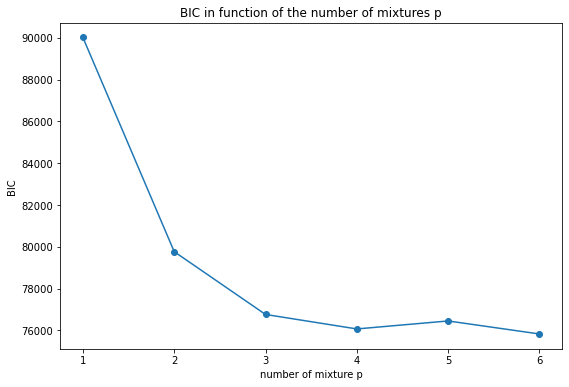

In [335]:
fig = plt.figure(figsize=(9,6))
plt.plot(range(1, M), bics, ls='-', marker='o')
plt.xlabel("number of mixture p")
plt.ylabel("BIC")
plt.title("BIC in function of the number of mixtures p")
plt.show()

On peut donc voir que plus $p$ est grand, plus le modèle est adapté à notre jeu de données. Le critère BIC ne permet pas d'éviter le sur-apprentissage. Cependant, on peut voir que ce critère stagne à partir de $p=3$, il semble donc que le modèle à $3$ composantes est le modèle le plus simple et le mieux adapté aux données.

## Exercice 3 : Importance sampling

### A. Poor Importance Sampling

In [3]:
mu = 0.8
sigma2 = 1.5
N = 10000

In [35]:
def f(x) :
    return 2*np.sin(np.pi*x / sigma2) * (x>=0)

def p(x) :
    return x**(0.65) * np.exp(-x**2/2) * (x>=0)

def q(x, mu=0.8) :
    return np.exp(-(x-mu)**2 / (2*sigma2)) / np.sqrt(2*sigma2)

In [63]:
def importance_sampling_estimator(x, f, p, q, mu=0.8) :
    "Importance sampling estimator with x drawn from q"
    return np.sum(f(x)*p(x)/q(x, mu))/np.sum(p(x)/q(x, mu))

In [43]:
def sample_from_q(mu=0.8, sigma2=1.5, N=10000) :
    x = np.zeros(N)
    for i in range(N) :
        y = np.random.normal(loc=mu, scale=sigma2)
        while y<0 :
            y = np.random.normal(loc=mu, scale=sigma2)
        x[i]=y
    return x #abs(np.random.normal(loc=mu, scale=sigma2, size=N))

In [44]:
x = sample_from_q(mu=0.8, sigma2=1.5, N=10000)

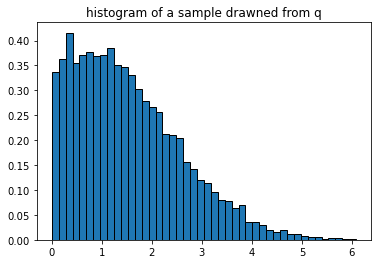

In [45]:
plt.hist(x, bins='auto', edgecolor="k", density=True)
plt.title("histogram of a sample drawned from q")
plt.show()

In [46]:
n = 1000
samples = np.zeros((4, n))

In [47]:
for i, N in enumerate([10, 100, 1000, 10_000]) :
    for j in range(n) :
        x = sample_from_q(0.8, 1.5, N)
        samples[i, j] = importance_sampling_estimator(x, f, p, q, mu=0.8)
    print("Importance sampling estimator for N = {} : {:.2f}".format(N, importance_sampling_estimator(x, f, p, q, mu=0.8)))

Importance sampling estimator for N = 10 : -0.10
Importance sampling estimator for N = 100 : 0.71
Importance sampling estimator for N = 1000 : 0.71
Importance sampling estimator for N = 10000 : 0.69


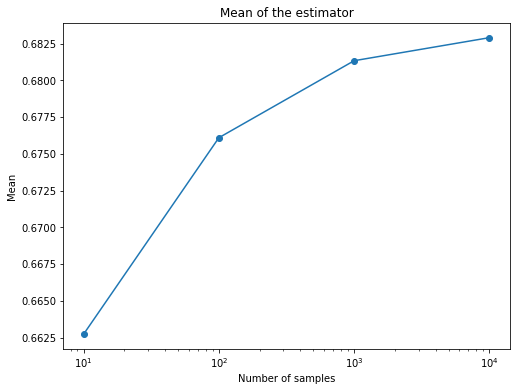

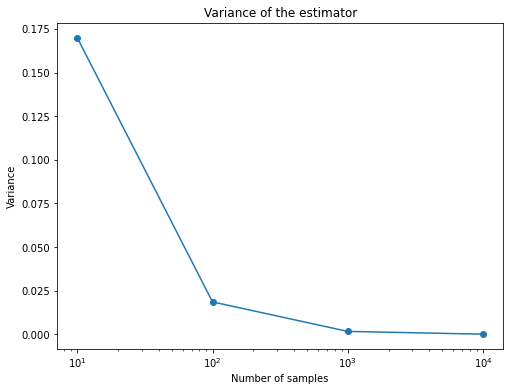

In [48]:
fig = plt.figure(figsize=(8, 6))
plt.plot([10, 100, 1000, 10_000], np.mean(samples, axis=1), marker='o')
plt.title("Mean of the estimator")
plt.xscale("log")
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.show()

fig = plt.figure(figsize=(8, 6))
plt.plot([10, 100, 1000, 10_000], np.var(samples, axis=1), marker='o')
plt.title("Variance of the estimator")
plt.xlabel("Number of samples")
plt.ylabel("Variance")
plt.xscale("log")
plt.show()

Let's shift the mean to $\mu = 6$ : 

In [51]:
for i, N in enumerate([10, 100, 1000, 10_000]) :
    for j in range(n) :
        x = sample_from_q(6, 1.5, N)
        samples[i, j] = importance_sampling_estimator(x, f, p, q, mu=6)
    print("Importance sampling estimator for N = {} : {:.2f}".format(N, importance_sampling_estimator(x, f, p, q, mu=6))) 

Importance sampling estimator for N = 10 : 1.22
Importance sampling estimator for N = 100 : -1.87
Importance sampling estimator for N = 1000 : -1.64
Importance sampling estimator for N = 10000 : 1.31


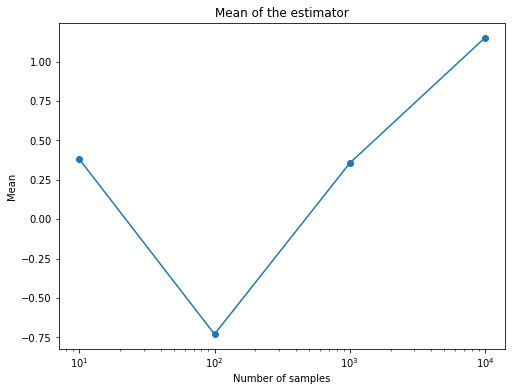

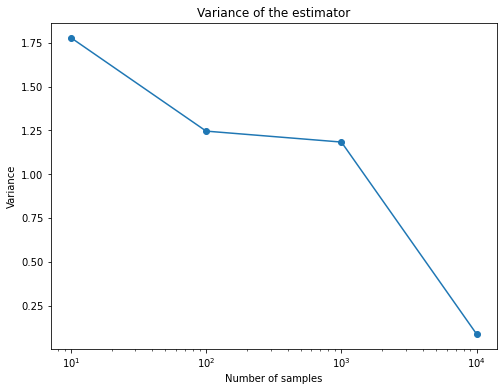

In [52]:
fig = plt.figure(figsize=(8, 6))
plt.plot([10, 100, 1000, 10_000], np.mean(samples, axis=1), marker='o')
plt.title("Mean of the estimator")
plt.xscale("log")
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.show()

fig = plt.figure(figsize=(8, 6))
plt.plot([10, 100, 1000, 10_000], np.var(samples, axis=1), marker='o')
plt.title("Variance of the estimator")
plt.xlabel("Number of samples")
plt.ylabel("Variance")
plt.xscale("log")
plt.show()

Comme attendu, avec la moyenne $\mu = 6$, l'estimateur par Importance Sampling a une grande variance, même si celle ci décroit nettement pour $N=10^4$. Observons les importance weights :

0.7382835004672867
0.9382987666415485


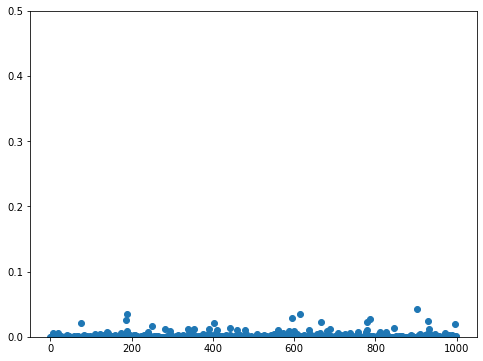

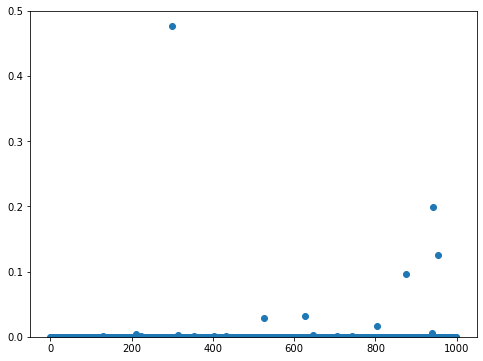

In [71]:
N = 1_000

fig = plt.figure(figsize=(8, 6))
y = sample_from_q(0.8, 1.5, N)
plt.plot(p(x)/q(x, mu=0.8) / np.sum(p(x)/q(x, mu=0.8)), 'o')
plt.ylim([0, 0.5])
print(np.linalg.norm(p(x)))

fig = plt.figure(figsize=(8, 6))
x = sample_from_q(6, 1.5, N)
plt.plot(p(x)/q(x, mu=6)/np.sum(p(x)/q(x, mu=6)), 'o')
plt.ylim([0, 0.5])
print(np.linalg.norm(p(x)))
plt.show()

Pour $\mu=0.8$, les poids sont quasiment tous non nuls, alors que pour $\mu=6$, ils sont proches de zeros.

### C. Application to a "banana"-shaped density

In [76]:
def adaptative_important_sampling(M, d, sigma2, b, N_ITER=100, size=100) :
    alpha = np.ones(M)/M
    mu = np.random.normal(0, 1, size=(M, d)) / 5 
    sigma = np.zeros((M, d, d))
    for j in range(M):
        sigma[j] = np.eye(d) # np.diag(1+np.random.normal(size=d)/10)
        sigma[j][0,0] = sigma2
   
    tau = np.ones((M, size))/M
    log_pdfs = np.ones((M, size))

    cst = -d/2*np.log(2*np.pi)

    Sigma_inv = np.eye(d)
    Sigma_inv[0, 0] = 1/sigma2

    for i in range(N_ITER) :
        Z = discrete_distribution(list(range(M)), alpha, size)
        X = np.zeros((size, d))
       
        for i in range(size) :
            j = int(Z[i])
            X[i] = np.random.multivariate_normal(mu[j], sigma[j])
        
        for j in range(M) :
            _, slogdet = np.linalg.slogdet(sigma[j])
            invers_sigma = np.linalg.inv(sigma[j])
            log_pdfs[j] = cst - slogdet/2 - np.einsum("ik, il, kl -> i", X-mu[j], X-mu[j], invers_sigma)/2
        log_weighted_pdfs = (log_pdfs.T + np.log(alpha)).T

        Y = np.copy(X)
        Y[:,1] -= b*(X[:,0]**2 - sigma2)

        omega = cst - d*np.log(sigma2)/2 - np.einsum("ik, il, kl -> i", Y, Y, Sigma_inv)/2   
        omega -= logsumexp(log_weighted_pdfs, axis=0)
        omega = np.exp(omega-logsumexp(omega)) 
        
        tau = np.exp(log_weighted_pdfs - logsumexp(log_weighted_pdfs, axis=0))
        tau = np.einsum("i, ji -> ji", omega, tau)

        ## Maximization Step
        for j in range(M) :
            Nj = np.sum(tau[j,:])
            mu[j] = np.einsum("i, ik -> k", tau[j,:], X) / Nj
            sigma[j] = np.einsum("k, ki, kj -> ij", tau[j,:], X-mu[j], X-mu[j]) / Nj
            alpha[j] = Nj

        
    return X, mu, sigma, alpha

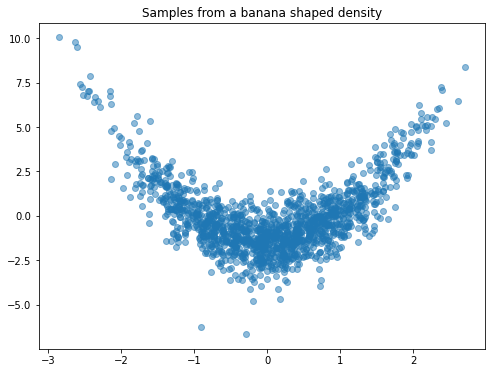

In [77]:
d = 5
sigma2 = 1
b = 1.4
M = 5

X, mu, sigma, alpha = adaptative_important_sampling(M, d, sigma2, b, N_ITER=60, size=1500)

fig = plt.figure(figsize=(8, 6))
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.title("Samples from a banana shaped density")
plt.show()

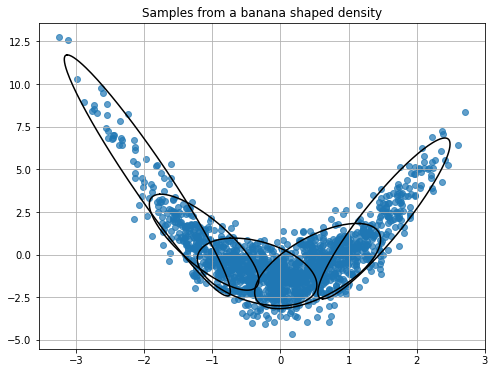

In [78]:
Z = discrete_distribution(list(range(M)), alpha, 10_000)
for i in range(500) :
    j = int(Z[i])
    X[i] = np.random.multivariate_normal(mu[j], sigma[j])
fig = plt.figure(figsize=(8, 6))
plt.scatter(X[:,0], X[:,1], alpha=0.7)
for j in range(M) :
    draw_ellipse(sigma[j][:2,:2], mu[j], scale=4)
plt.grid()
plt.title("Samples from a banana shaped density")
plt.show()